# Feature Engineering: HI-Small_Trans Dataset

This notebook builds on insights from the exploratory analysis to engineer new features that may help distinguish laundering transactions from legitimate ones. These features are designed to capture behavioral patterns, structural anomalies and contextual signals that could improve model performance.


## 1. Imports and Setup
Import core libraries for data manipulation and visualisation. Seaborn is used for styling plots.

In [11]:
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))  
OUTPUT_DIR = os.path.join(BASE_DIR, "outputs")
os.makedirs(OUTPUT_DIR, exist_ok=True)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

from src.data_loader import load_transaction_data
from src.feature_engineering import engineer_features, encode_high_cardinality_features
from src.report_utils import get_feature_engineering_summary, summarise_features

sns.set_theme(style="whitegrid")


## 2. Custom function to apply feature engineering

Derives additional features based on the to amount and from amount, currency, bank, frequency of transaction and time and date elements.

It also applies a log transformation to the transaction amounts to handle the negatively skewed distribution observed in exploratory analysis. 

In [19]:
df = load_transaction_data("../data/raw/HI-Small_Trans.csv.gz", verbose=False)
df_trans = engineer_features(df)
#df_trans.head()
df_trans.dtypes


Encoding high-cardinality features: ['from_bank', 'account', 'to_bank', 'account.1']


timestamp                  datetime64[ns]
from_bank                         float64
account                           float64
to_bank                           float64
account.1                         float64
receiving_currency               category
payment_currency                 category
payment_format                   category
is_laundering                       int64
payment_format_code                  int8
same_bank                            bool
sender_freq                         int64
receiver_freq                       int64
hour                                int32
day_of_week                        object
off_hours                            bool
is_weekend                           bool
log_amount_paid                   float64
log_amount_received               float64
log_sender_freq                   float64
log_receiver_freq                 float64
sender_freq × off_hours             int64
sender_freq_bin                     int64
dtype: object

### Post-Engineering Feature Analysis

In [3]:
df_trans.shape

(5078345, 22)

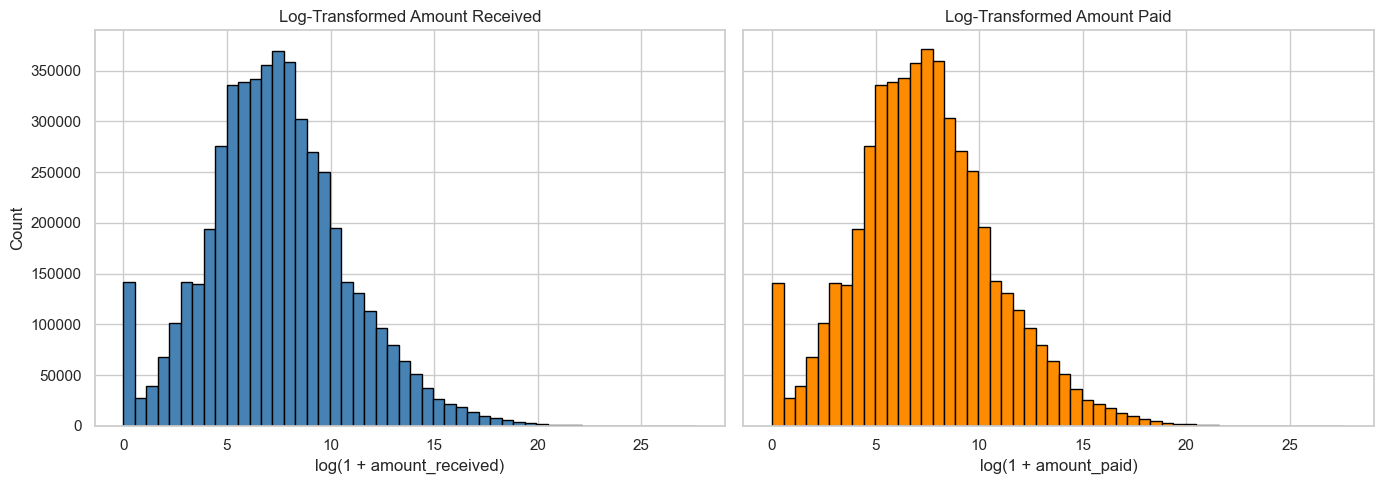

In [4]:
# Apply log transformation (add small constant to avoid log(0))
#df["log_amount_received"] = np.log1p(df["amount_received"])
#df["log_amount_paid"] = np.log1p(df["amount_paid"])

# Plot side-by-side histograms
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

axes[0].hist(df_trans["log_amount_received"], bins=50, color="steelblue", edgecolor="black")
axes[0].set_title("Log-Transformed Amount Received")
axes[0].set_xlabel("log(1 + amount_received)")
axes[0].set_ylabel("Count")

axes[1].hist(df_trans["log_amount_paid"], bins=50, color="darkorange", edgecolor="black")
axes[1].set_title("Log-Transformed Amount Paid")
axes[1].set_xlabel("log(1 + amount_paid)")

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "log_amount_histograms.png"), dpi=300)
plt.show()

In [5]:
df_trans.nunique().sort_values()


is_weekend                      2
off_hours                       2
same_bank                       2
is_laundering                   2
sender_freq_bin                 4
payment_format                  7
day_of_week                     7
payment_currency               15
receiving_currency             15
hour                           24
receiver_freq                 109
account.1                     109
log_receiver_freq             109
log_sender_freq               264
sender_freq                   264
account                       264
sender_freq × off_hours       265
from_bank                    1282
to_bank                      1536
timestamp                   15018
log_amount_received        915161
log_amount_paid            923873
dtype: int64

In [6]:
# New Features

# Identify newly added features
original_cols = set(df.columns)
transformed_cols = set(df_trans.columns)
new_features = list(transformed_cols - original_cols)

# Create a DataFrame with only the new features
df_new_features = df_trans[new_features]

new_feats_sum = summarise_features(df_new_features)

print(new_feats_sum.to_markdown(index=False))
new_feats_sum.to_csv(os.path.join(OUTPUT_DIR, "new_feats_sum.csv"), index=False)

| Feature                 | Data Type   |   Unique Values |   Missing Values |
|:------------------------|:------------|----------------:|-----------------:|
| log_amount_paid         | Decimal     |          923873 |                0 |
| log_amount_received     | Decimal     |          915161 |                0 |
| sender_freq × off_hours | Integer     |             265 |                0 |
| log_sender_freq         | Decimal     |             264 |                0 |
| sender_freq             | Integer     |             264 |                0 |
| receiver_freq           | Integer     |             109 |                0 |
| log_receiver_freq       | Decimal     |             109 |                0 |
| hour                    | Integer     |              24 |                0 |
| day_of_week             | Text        |               7 |                0 |
| sender_freq_bin         | Integer     |               4 |                0 |
| off_hours               | Boolean     |           

## 3. Baseline Model for Feature Selection
Use a random forest classifier to check for most informative features. 

In [3]:
top_features_sets = []

for seed in [42, 101, 202]:
    # Sample 10% of the data
    df_sample, _ = train_test_split(df_trans, test_size=0.90, stratify=df_trans["is_laundering"], random_state=seed)
    X = df_sample.drop(columns=["is_laundering"])
    y = df_sample["is_laundering"]

    # Drop non-numeric columns (e.g., unencoded strings)
    X_copy = X.select_dtypes(include=["number", "bool"]).copy()

    # F1 scores per feature
    f1_scores = {}
    for feature in X_copy.columns:
        clf = RandomForestClassifier(n_estimators=25, random_state=seed)
        score = cross_val_score(clf, X_copy[[feature]], y, cv=3, scoring=make_scorer(f1_score), n_jobs=-1).mean()
        f1_scores[feature] = score

    top_features = sorted(f1_scores, key=f1_scores.get, reverse=True)[:10]
    top_features_sets.append(set(top_features))

# Compare overlap
common_features = set.intersection(*top_features_sets)
print("Common top features across samples:", common_features)


Common top features across samples: {'sender_freq', 'from_bank', 'payment_format_code', 'same_bank', 'account.1', 'log_amount_received', 'to_bank', 'receiver_freq', 'account', 'log_amount_paid'}


In [10]:

# Build markdown table
print("| Feature Group              | Details                                      |")
print("|----------------------------|----------------------------------------------|")
print(f"| Zero F1 Score Features     | {', '.join(zero_features)} |")
for feature, score in nonzero_features.items():
    print(f"| {feature:<26} | {score:.4f} |")


| Feature Group              | Details                                      |
|----------------------------|----------------------------------------------|
| Zero F1 Score Features     | from_bank, account, to_bank, account.1, payment_format_code, same_bank, sender_freq, receiver_freq, hour, off_hours, is_weekend, log_sender_freq, log_receiver_freq, sender_freq × off_hours, sender_freq_bin |
| log_amount_paid            | 0.0045 |
| log_amount_received        | 0.0045 |


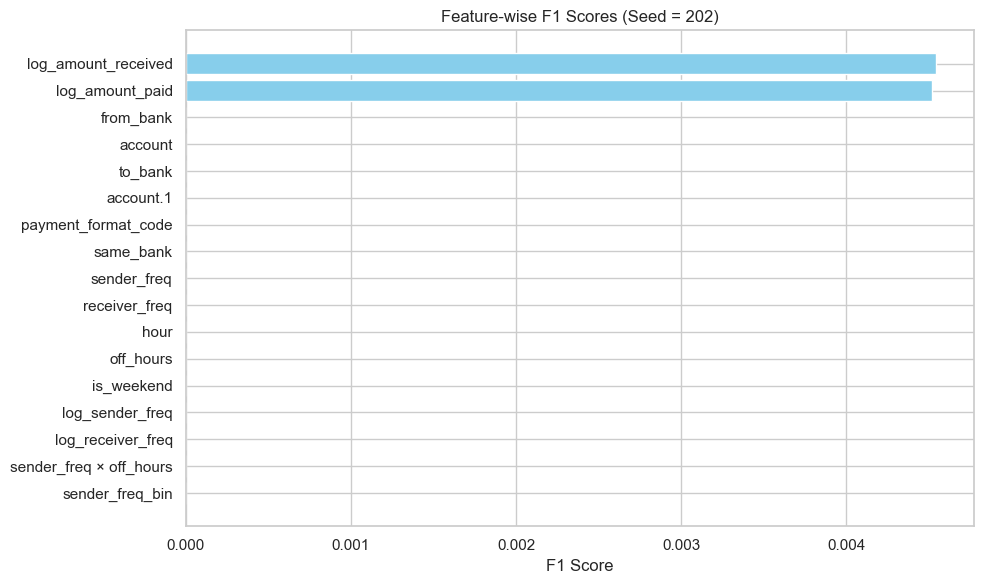

In [4]:
# Use the last f1_scores dictionary (from seed=202)
feature_scores = f1_scores
sorted_features = sorted(feature_scores.items(), key=lambda x: x[1], reverse=True)

features = [f[0] for f in sorted_features]
scores = [f[1] for f in sorted_features]

plt.figure(figsize=(10, 6))
plt.barh(features, scores, color="skyblue")
plt.xlabel("F1 Score")
plt.title("Feature-wise F1 Scores (Seed = 202)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [13]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_copy, y)

f1_scores = {}
for feature in X_resampled.columns:
    clf = RandomForestClassifier(n_estimators=25, random_state=42)
    score = cross_val_score(clf, X_resampled[[feature]], y_resampled, cv=3, scoring=make_scorer(f1_score), n_jobs=-1).mean()
    f1_scores[feature] = score

top_features = sorted(f1_scores, key=f1_scores.get, reverse=True)[:10]
print("Top features after SMOTE-based selection:", top_features)


Top features after SMOTE-based selection: ['to_bank', 'from_bank', 'account.1', 'log_receiver_freq', 'account', 'log_sender_freq', 'payment_format_code', 'sender_freq × off_hours', 'sender_freq', 'log_amount_received']


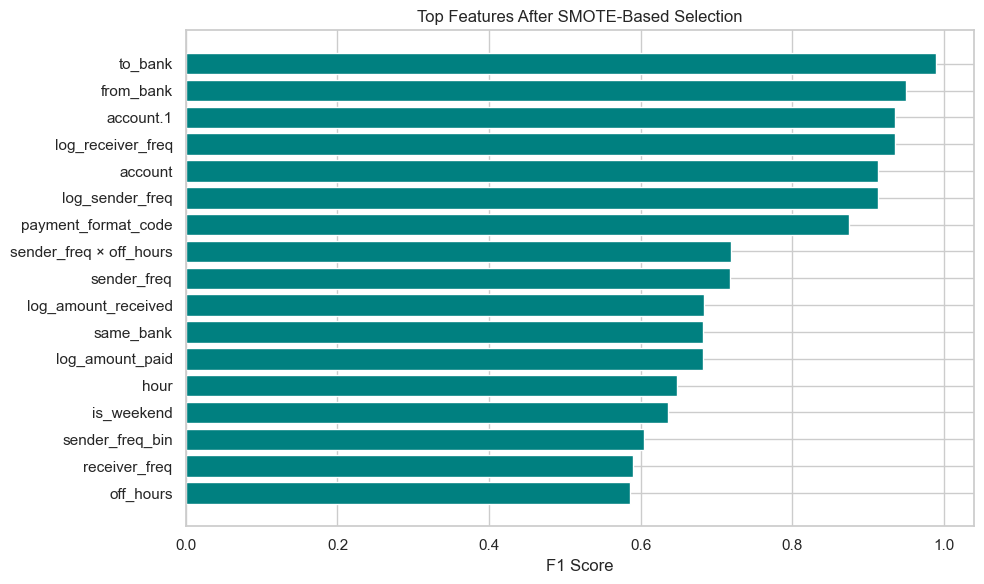

In [16]:
# Sort features by score
sorted_scores = dict(sorted(f1_scores.items(), key=lambda item: item[1], reverse=True))

# Plot
plt.figure(figsize=(10, 6))
plt.barh(list(sorted_scores.keys())[::-1], list(sorted_scores.values())[::-1], color='teal')
plt.xlabel("F1 Score")
plt.title("Top Features After SMOTE-Based Selection")
plt.tight_layout()
plt.show()
